In [6]:
#!Get-Item Env:HUGGINGFACE_TOKEN
#!huggingface-cli login --token $HUGGINGFACE_TOKEN

#AFAICT this is straight up broken on Windows, I just logged manually via a terminal window 

In [7]:
import torch

torch.cuda.is_available()

True

In [8]:
mem = torch.cuda.mem_get_info()
before_VRAM_usage = (mem[1]-mem[0])/1000000000

In [9]:
use_SD3 = False
use_SD1 = not(use_SD3)

drop_t5 = False

if use_SD3:
    from diffusers import StableDiffusion3Pipeline
    if not(drop_t5):
        pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", 
                                                        torch_dtype=torch.float16)
    else:
        pipe = StableDiffusion3Pipeline.from_pretrained(
            "stabilityai/stable-diffusion-3-medium-diffusers", 
            text_encoder_3=None,
            tokenizer_3=None,
            torch_dtype=torch.float16
        )

    pipe.to("cuda")

In [10]:
if use_SD1:
    from diffusers import StableDiffusionPipeline

    #So err runway took down SD1.5 right in the middle of my project :P
    #https://huggingface.co/posts/dn6/357701279407928#66d19308974c5c69027709b0
    #Original repo was at
    #https://huggingface.co/runwayml/stable-diffusion-v1-5
    #Currently using
    #https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5

    pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True, torch_dtype=torch.float16)
    pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/home/joy/miniconda3/envs/SD3HF/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


Started: 15:58:30.887050


100%|██████████| 50/50 [00:02<00:00, 19.51it/s]


Ended: 15:58:56.002836
Took: 0:00:25.115786


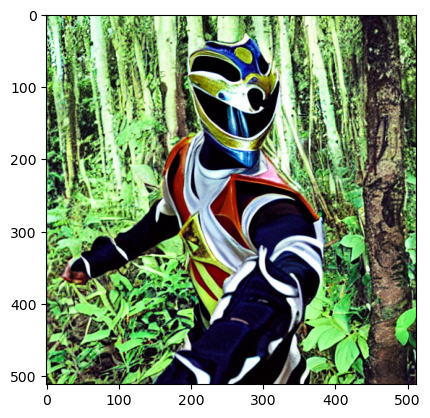

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

num_iter = 10
start_time = datetime.now()
print(f"Started: {start_time.time()}")

for i in range(num_iter):
    prompt_str = "a power ranger in the jungle"

    if use_SD3:
        image = pipe(
            prompt=prompt_str,
            negative_prompt="",
            num_inference_steps=50, #default is 28
            height=512, #default is 1024
            width=512,  #default is 1024
            guidance_scale=7.0,
        ).images[0]

        #image.save("sd3_hello_world.png")

    if use_SD1:
        image = pipe(
            prompt=prompt_str,
        ).images[0]

    plt.imshow(image)

end_time = datetime.now()
print(f"Ended: {end_time.time()}")
time_taken = end_time-start_time
print((f"Took: {time_taken}"))

10 Iterations:
- SD1: 33s
- SD3 (default): 2min 52s
- SD3 w/o T5 (default): 2min 52s
- SD3 (50/512): 1min 13s
- SD3 w/o T5 (50/512): 1min 1s

SD3 (default) using 28 inference steps, output res of 1024x1024
SD1 using 50 inference steps with an output res of 512x512

Lab Machine
- SD1: 40s
- SD3 (50/512): DNS (did not start)
- SD3 w/o T5 (50/512): 1min 1s

Lets breakdown the stable diffusion into its consitutent parts.

First we have the text encoders and tokenizers.

In [12]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.2",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [13]:

print(f"VRAM Usage Before: {before_VRAM_usage} GB")
mem = torch.cuda.mem_get_info()
after_VRAM_usage = (mem[1]-mem[0])/1000000000
print(f"VRAM Usage After: {after_VRAM_usage} GB")
print(f"VRAM Delta: {after_VRAM_usage-before_VRAM_usage} GB")

VRAM Usage Before: 0.27262976 GB
VRAM Usage After: 4.263510016 GB
VRAM Delta: 3.9908802559999996 GB


Matched Settings
- SD1.5 uses 4GB of VRAM
- SD3 uses 19GB of VRAM
- SD3 without T5 uses 7GB of VRAM


Default Settings
- SD1.5 uses 4GB of VRAM
- SD3 uses 22GB of VRAM
- SD3 without T5 uses 11GB of VRAM

In [14]:
if False:
    #CLIP ViT-Large
    print(SD3_pipe.text_encoder)
    print(SD3_pipe.tokenizer)
    #CLIP ViT-Big
    print(SD3_pipe.text_encoder_2)
    print(SD3_pipe.tokenizer_2)
    #T5 v1 XXL
    print(SD3_pipe.text_encoder_3)
    print(SD3_pipe.tokenizer_3)

Next we have the variational autoencoder

In [15]:
if False:
    #Autoencoder KL
    print(SD3_pipe.vae)